# 📦 Import Libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # for saving scaler

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import time

# Set device and check for CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Optional: Print PyTorch version and CUDA version
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda if torch.version.cuda else 'Not available'}")

CUDA is available. Using GPU: Quadro RTX 5000 with Max-Q Design
PyTorch version: 2.7.0+cu128
CUDA version: 12.8


# 📥 Load Data

## Load training and test datasets

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
test_ids = test_df["Id"]

## Separate the target variable

In [3]:
y = np.log1p(
    train_df["SalePrice"].values.reshape(-1, 1)
)  # log-transform to reduce skew
train_df = train_df.drop(["SalePrice"], axis=1)
target_scaler = StandardScaler()
y = target_scaler.fit_transform(y)  # now standardize the log-transformed prices

## Combine for consistent preprocessing

In [4]:
full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# 🔍 Check Missing Values

## Check and visualize missing data

In [5]:
missing_data = full_df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print("Missing values per column:")
print(missing_data)

Missing values per column:
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
Functional         2
BsmtHalfBath       2
Utilities          2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
KitchenQual        1
GarageArea         1
GarageCars         1
SaleType           1
dtype: int64


## Visualize missing values

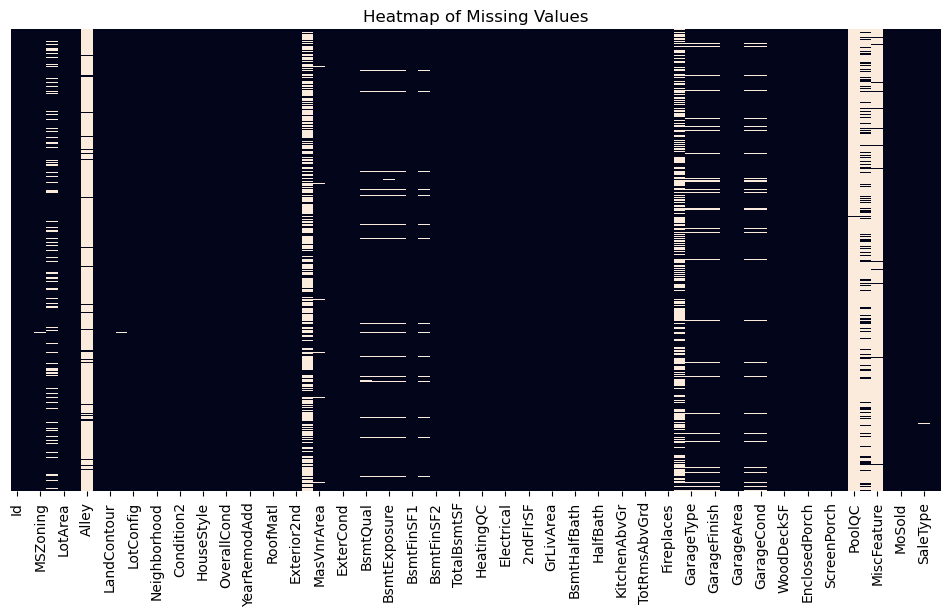

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(full_df.isnull(), cbar=False, yticklabels=False)
plt.title("Heatmap of Missing Values")
plt.show()

# 🧹 Handle Missing Values

## Impute numeric features with median

In [7]:
numeric_features = full_df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy="median")
full_df[numeric_features] = imputer.fit_transform(full_df[numeric_features])

## Impute categorical features with mode

In [8]:
categorical_features = full_df.select_dtypes(include=[object]).columns
for col in categorical_features:
    full_df[col] = full_df[col].fillna(full_df[col].mode()[0])

# 🔤 One-Hot Encode Categoricals

# One-hot encode categorical variables

In [9]:
full_df = pd.get_dummies(full_df)

# 🔀 Separate train/test features again


In [10]:
X_train = full_df.iloc[: len(y), :]
X_test = full_df.iloc[len(y) :, :]

## Standardize features

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Save the scaler

In [12]:
scaler_path = Path("models/scaler.pkl")
scaler_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Scaler saved to models/scaler.pkl


# 📈 Correlation Heatmap

## Correlation heatmap for top 15 features

In [13]:
train_copy = pd.DataFrame(X_train, columns=full_df.columns[: X_train.shape[1]])
train_copy["SalePrice"] = y  # y.values
corr_matrix = train_copy.corr()
top_corr_features = corr_matrix["SalePrice"].abs().sort_values(ascending=False).head(15)

## Visualize heatmap of top features

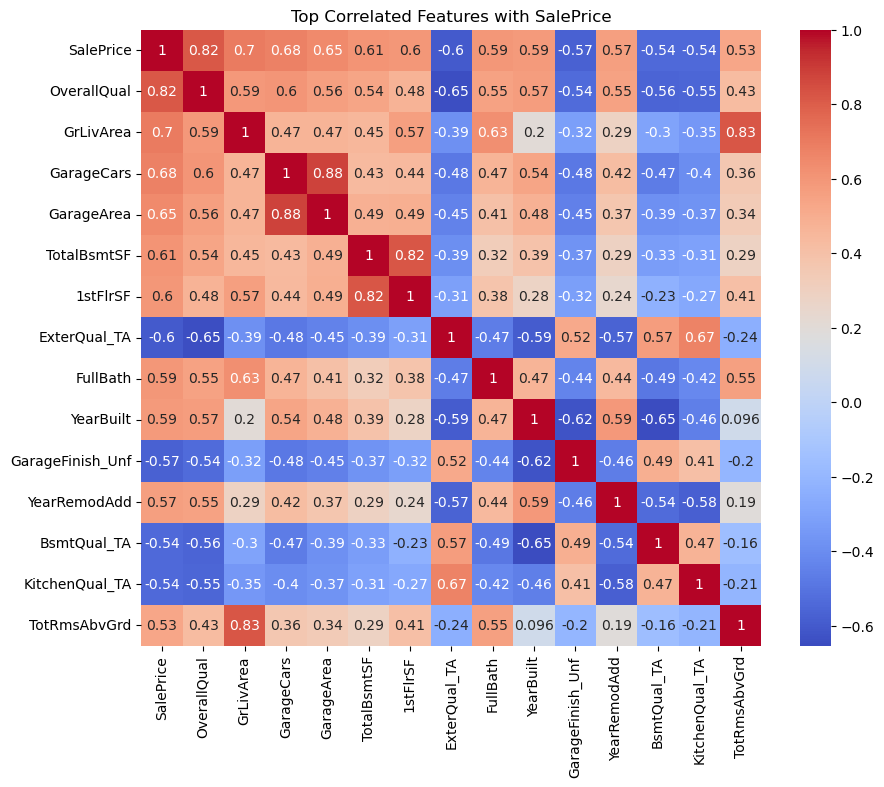

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_copy[top_corr_features.index].corr(), annot=True, cmap="coolwarm")
plt.title("Top Correlated Features with SalePrice")
plt.show()

# 🔁 Convert to PyTorch Tensors

## Convert to tensors

In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

## DataLoader

In [16]:
train_dataset = TensorDataset(X_train_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 🧠 Define the Model

### Define HousePriceModel Class

In [17]:
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)

## Initialize the model

In [18]:
model = HousePriceModel(X_train.shape[1]).to(device)

# 🏋️ Train Model + TensorBoard

## Logging setup

In [19]:
log_dir = Path("runs/house_prices_experiment")
log_dir.mkdir(parents=True, exist_ok=True)

writer = SummaryWriter(log_dir=str(log_dir))
writer.add_scalar("test/init", 1.0, 0)
writer.flush()

print(f"TensorBoard logs will be written to: {log_dir}")

TensorBoard logs will be written to: runs/house_prices_experiment


## Training setup

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Initialize early stopping parameters

In [21]:
best_loss = float("inf")  # Best loss seen so far
patience = 20  # Stop if no improvement after this many epochs
trigger_times = 0  # Counts epochs without improvement

## Training loop

In [22]:
try:
    for epoch in range(1000):
        total_loss = 0.0  # Accumulate loss for the epoch

        # Loop through batches of training data
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Average loss for epoch
        avg_loss = total_loss / len(train_loader)

        # Log average loss to TensorBoard
        writer.add_scalar("Loss/train", avg_loss, epoch)
        writer.flush()  # Explicitly flush logs

        # Early stopping logic
        if avg_loss < best_loss:
            best_loss = avg_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

finally:
    writer.close()  # Always ensure the writer is closed properly

Epoch 10, Loss: 0.0471
Epoch 20, Loss: 0.0281
Epoch 30, Loss: 0.0302
Epoch 40, Loss: 0.0240
Epoch 50, Loss: 0.0207
Epoch 60, Loss: 0.0190
Epoch 70, Loss: 0.0163
Epoch 80, Loss: 0.0151
Epoch 90, Loss: 0.0143
Epoch 100, Loss: 0.0145
Epoch 110, Loss: 0.0131
Epoch 120, Loss: 0.0117
Epoch 130, Loss: 0.0140
Epoch 140, Loss: 0.0118
Epoch 150, Loss: 0.0103
Epoch 160, Loss: 0.0090
Epoch 170, Loss: 0.0089
Epoch 180, Loss: 0.0093
Early stopping at epoch 182


# 📤 Predictions & Submissions

## Inference

In [23]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.to(device)).cpu().numpy().flatten()

## Save predictions

In [24]:
raw_preds = model(X_test_tensor.to(device)).detach().cpu().numpy()
scaled_preds = target_scaler.inverse_transform(raw_preds)  # undo standard scaling
predictions = np.expm1(scaled_preds).flatten()  # undo log1p

submission = pd.DataFrame({"Id": test_ids, "SalePrice": predictions})
submission.to_csv("submission.csv", index=False)
print("Submission saved to 'submission.csv'")

Submission saved to 'submission.csv'


## Save model

In [25]:
model_path = Path("models/trained_model.pt")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to models/trained_model.pt


## Load model later

In [26]:
# Recreate the model architecture
loaded_model = HousePriceModel(X_train.shape[1])

# Safely load the saved weights
state_dict = torch.load(model_path, map_location=device, weights_only=True)
loaded_model.load_state_dict(state_dict)

# Move model to device and set to eval mode
loaded_model.to(device)
loaded_model.eval()

print("Model successfully loaded for inference")

Model successfully loaded for inference
